In [181]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models, Model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import random
import time

In [182]:
activation_functions = {
    'tanh': tf.tanh,
    'relu': tf.nn.relu,
    'sigmoid': tf.nn.sigmoid,
    'linear': tf.keras.activations.linear,
    'softmax': tf.nn.softmax,
}

**Loading Data**

In [183]:
%%time

# numpy
_, (X_test, y_test) = mnist.load_data() # only care  about X_test

X_test = X_test.reshape(10000, 784).astype(np.float32) / 255.0
y_test = to_categorical(y_test)  # one-hot encoding

# tensorflow
X_test = tf.convert_to_tensor(np.transpose(X_test))
y_test = tf.convert_to_tensor(np.transpose(y_test))

CPU times: total: 266 ms
Wall time: 238 ms


**Network Definition**

In [184]:
MUTATE_RATE_MATRIX = 0.3
MUTATE_RATE_BIAS = 0.1
MUTATE_RATE_ACTIVATION_FUNCTION = 0.1
GAUSSIAN_NOISE_STDDEV = 1   # mutation applies additive gaussian noise
UNIFORM_CROSSOVER = False   # if True, performs crossover of matrices element-wise, else row-wise
HIDDEN_LAYER_WIDTH = 32     # TODO: for now all hidden layers same width

In [185]:
class MultiLayerPerceptron(Model):
    def __init__(self, **params):
        """
        Weight gnostic multi-layer feed forward neural network
        :param params: Params have to be in form: (matrix1=..., bias1=..., activations1=..., matrix2=..., ...)
        """
        super(MultiLayerPerceptron, self).__init__()

        self.n_layers = max([int(param_name[-1]) for param_name in params.keys()])   # = number of hidden layers + 1 (output layer)

        for (param_name, param) in params.items():
            assert param_name[:-1] in ('matrix', 'bias', 'activation'), 'Invalid attribute!'
            setattr(self, param_name, param)

    def call(self, inputs):
        x = inputs

        for layer in range(1, self.n_layers + 1):
            x = getattr(self, 'matrix' + str(layer)) @ x
            x += getattr(self, 'bias' + str(layer))
            x = activation_functions[getattr(self, 'activation' + str(layer))](x)

        return x

    # TODO: without custom function?
    def evaluate(self):
        y_pred = np.argmax(self.call(X_test), axis=0)
        y_true = np.argmax(y_test, axis=0)
        return np.mean(y_pred == y_true)

    def subset_evaluate(self, subset=0.5):
        selection = np.random.choice(np.arange(np.shape(X_test)[0]),
                                     int(subset * np.shape(X_test)[0]),
                                     replace=False)
        y_pred = np.argmax(self.call(X_test[selection]), axis=0)
        y_true = np.argmax(y_test[selection], axis=0)
        return np.mean(y_pred == y_true)

    def mutate(self):
        for layer in range(1, self.n_layers + 1):
            # matrix
            matrix = getattr(self, 'matrix' + str(layer))
            mutation_stencil = tf.cast(tf.reshape(tf.random.categorical(
                tf.math.log([[1 - MUTATE_RATE_MATRIX, MUTATE_RATE_MATRIX]]),
                matrix.shape[0] * matrix.shape[1]), matrix.shape), tf.float32)
            noise = tf.random.normal(mean=0.0, stddev=GAUSSIAN_NOISE_STDDEV, shape=matrix.shape)
            matrix = matrix + tf.multiply(mutation_stencil, noise)
            setattr(self, 'matrix' + str(layer), matrix)

            # bias
            bias = getattr(self, 'bias' + str(layer))
            mutation_stencil = tf.cast(tf.reshape(tf.random.categorical(
                tf.math.log([[1 - MUTATE_RATE_BIAS, MUTATE_RATE_BIAS]]),
                bias.shape[0]), bias.shape), tf.float32)
            noise = tf.random.normal(mean=0.0, stddev=GAUSSIAN_NOISE_STDDEV, shape=bias.shape)
            bias = bias + tf.multiply(mutation_stencil, noise)
            setattr(self, 'bias' + str(layer), bias)

            # activation
            cleaner = lambda x: 'softmax' if x=='softmax_v2' else x
            activation = cleaner(getattr(self, 'activation' + str(layer)))
            if random.uniform(0, 1) < MUTATE_RATE_ACTIVATION_FUNCTION:
                activation = random.choice(list(activation_functions.keys()))
            setattr(self, 'activation' + str(layer), activation)

    def summary(self):
        dash = '-' * 75
        ddash = '=' * 75
        print(dash)
        print('Model')
        print(ddash)

        n_params = 0
        for layer in range(1, self.n_layers + 1):
            # get values
            matrix = getattr(self, 'matrix' + str(layer))
            bias = getattr(self, 'bias' + str(layer))
            cleaner = lambda x: 'softmax' if x=='softmax_v2' else x
            activation = cleaner(getattr(self, 'activation' + str(layer)))

            n_params += matrix.shape[0] * matrix.shape[1] + bias.shape[0] + 1

            # print adjustments
            activation = '({})'.format(activation)
            layer_IO = '(in={}, out={})'.format(matrix.shape[1], matrix.shape[0],)

            print('Linear {:<20}{:<30}#Params: {}'.format(activation, layer_IO, matrix.shape[0] * matrix.shape[1] + bias.shape[0] + 1))

        print(ddash)
        print('Total params: {}'.format(n_params))
        print('Accuracy: {}\n'.format(self.evaluate()))

In [186]:
class Population:
    # TODO: n_layers evolvable
    def __init__(self, size=10, n_survivors=5, n_hidden_layers=1):
        """
        :param size: population size
        :param n_survivors: number of survivors after each generation (rest is killed and unable to pass on its genes)
        :param n_hidden_layers: number of hidden layers
        """
        self.generation = 0
        self.size = size
        self.n_survivors = n_survivors
        self.n_hidden_layers = n_hidden_layers
        self.elite = None
        self.fitness = None # cache fitness for increased speed
        self.fitness_generation = -1  # generation when fitness was evaluated

        # initialization (gaussian)
        # TODO: hidden layer width fixed for now
        self.organisms = []
        for _ in range(size):
            params = {}

            # first hidden layer
            params['matrix1'] = tf.random.normal(mean=0.0, stddev=1.0, shape=[HIDDEN_LAYER_WIDTH, 784])
            params['bias1'] = tf.random.normal(mean=0.0, stddev=1.0, shape=[HIDDEN_LAYER_WIDTH, 1])
            params['activation1'] = 'sigmoid'

            for hidden_layer in range(2, n_hidden_layers + 2):
                params['matrix' + str(hidden_layer)] = tf.random.normal(mean=0.0, stddev=1.0, shape=[HIDDEN_LAYER_WIDTH, HIDDEN_LAYER_WIDTH])
                params['bias' + str(hidden_layer)] = tf.random.normal(mean=0.0, stddev=1.0, shape=[HIDDEN_LAYER_WIDTH, 1])
                params['activation' + str(hidden_layer)] = 'sigmoid'

            # output layer
            params['matrix' + str(self.n_hidden_layers + 1)] = tf.random.normal(mean=0.0, stddev=1.0, shape=[10, HIDDEN_LAYER_WIDTH])
            params['bias' + str(self.n_hidden_layers + 1)] = tf.random.normal(mean=0.0, stddev=1.0, shape=[10, 1])
            params['activation' + str(self.n_hidden_layers + 1)] = 'softmax'

            model = MultiLayerPerceptron(**params)
            self.organisms.append(model)

        self.history = [(max(self.organism_fitness()), self.average_fitness())]   # fitness of population over all generations

    def organism_fitness(self):
        if self.generation != self.fitness_generation:
            self.fitness = [organism.evaluate() for organism in self.organisms]
            self.fitness_generation = self.generation

        return self.fitness

    def average_fitness(self):
        organism_fitness = self.organism_fitness()
        return sum(organism_fitness) / len(organism_fitness)

    def max_fitness(self):
        return max(self.organism_fitness())

    def selection(self):
        organism_fitness = self.organism_fitness()

        # elitism (n=1)
        elite_index = np.argmax(organism_fitness)
        self.elite = self.organisms.pop(elite_index)
        organism_fitness.pop(elite_index)

        probabilities = [fitness / sum(organism_fitness) for fitness in organism_fitness]  # normalized
        survivors = np.random.choice(self.organisms,
                                     size=self.n_survivors - 1,
                                     p=probabilities,
                                     replace=False)
        return [survivor for survivor in survivors]

    def crossover(self, parents):
        children = []
        while len(children) < (self.size - 1):
            [father, mother] = random.sample(parents + [self.elite], k=2)  # sample without replacement

            child_params = {}
            for layer in range(1, father.n_layers + 1):
                if UNIFORM_CROSSOVER:
                    # matrix - uniform crossover
                    father_matrix = getattr(father, 'matrix' + str(layer))
                    mother_matrix = getattr(mother, 'matrix' + str(layer))

                    father_mask = tf.round(tf.random.uniform(father_matrix.shape))
                    mother_mask = - (father_mask - 1)

                    child_matrix = tf.multiply(father_mask, father_matrix) + tf.multiply(mother_mask, mother_matrix)
                    child_params['matrix' + str(layer)] = child_matrix
                else:
                    # matrix - row-wise (neuron-wise) crossover
                    father_matrix = getattr(father, 'matrix' + str(layer))
                    mother_matrix = getattr(mother, 'matrix' + str(layer))

                    n_rows = father_matrix.shape[0]
                    father_mask = np.random.choice([True, False], size=n_rows)

                    child_matrix = tf.convert_to_tensor([father_matrix[row, :] if father_mask[row] \
                                                         else mother_matrix[row, :] for row in range(n_rows)])
                    child_params['matrix' + str(layer)] = child_matrix

                # bias - uniform crossover
                father_bias = getattr(father, 'bias' + str(layer))
                mother_bias = getattr(mother, 'bias' + str(layer))

                father_mask = tf.round(tf.random.uniform(father_bias.shape))
                mother_mask = - (father_mask - 1)

                child_bias = tf.multiply(father_mask, father_bias) + tf.multiply(mother_mask, mother_bias)
                child_params['bias' + str(layer)] = child_bias

                # activation
                cleaner = lambda x: 'softmax' if x=='softmax_v2' else x
                father_activation = cleaner(getattr(father, 'activation' + str(layer)))
                mother_activation = cleaner(getattr(mother, 'activation' + str(layer)))

                child_activation = father_activation if (random.uniform(0, 1) < 0.5) else mother_activation
                child_params['activation' + str(layer)] = child_activation

            model = MultiLayerPerceptron(**child_params)
            children.append(model)

        return children

    def mutate(self, organisms):
        for organism in organisms:
            organism.mutate()

    def breed(self):
        parents = self.selection()
        children = self.crossover(parents)
        self.mutate(children)  # TODO: mGA or GA?
        self.organisms = children + [self.elite]
        self.generation += 1
        self.history.append((self.max_fitness(), self.average_fitness()))

    def plot(self):
        # plot evolution
        plt.figure()
        plt.plot(np.arange(self.generation + 1), [score[0] for score in self.history],
                 label='max fitness')
        plt.plot(np.arange(self.generation + 1), [score[1] for score in self.history],
                 label='avg fitness', alpha=0.6)
        plt.title('Population fitness' + ' (n=' + str(self.size) + ')')
        plt.xlabel('Generations')
        plt.ylabel('Fitness score (accuracy)')
        plt.legend()
        plt.show()

        # plot best performing final network
        organism_fitness = self.organism_fitness()
        elite_index = np.argmax(organism_fitness)
        self.organisms[elite_index].summary()

**Training**

In [187]:
# initialization
GENERATIONS = 3500
POPULATION_SIZE = 30
SURVIVORS = 15
N_HIDDEN_LAYERS = 1

Starting training
Gen 0 : [0.0837, 0.087, 0.0987, 0.0858, 0.1052, 0.0827, 0.0715, 0.1121, 0.0987, 0.0929, 0.1283, 0.1142, 0.0889, 0.0736, 0.0739, 0.1451, 0.113, 0.1199, 0.0697, 0.1038, 0.102, 0.1493, 0.1423, 0.187, 0.1072, 0.0751, 0.1208, 0.113, 0.1057, 0.1373] - max: 0.187 (0.27s)
Gen 1 : [0.1516, 0.0844, 0.118, 0.1308, 0.0903, 0.0872, 0.1347, 0.0973, 0.0749, 0.1437, 0.091, 0.0778, 0.0875, 0.0756, 0.0903, 0.1127, 0.107, 0.0887, 0.0898, 0.136, 0.1191, 0.093, 0.1278, 0.0805, 0.1047, 0.0804, 0.1226, 0.1122, 0.1004, 0.187] - max: 0.187 (0.66s)
Gen 2 : [0.1123, 0.1047, 0.1078, 0.1152, 0.1532, 0.1095, 0.1072, 0.0978, 0.0879, 0.0994, 0.1453, 0.1149, 0.1324, 0.0905, 0.1202, 0.0785, 0.1072, 0.0988, 0.1259, 0.099, 0.0951, 0.1179, 0.1084, 0.1146, 0.1215, 0.1557, 0.1351, 0.1425, 0.1087, 0.187] - max: 0.187 (0.58s)
Gen 3 : [0.1141, 0.1142, 0.0842, 0.1011, 0.0964, 0.0914, 0.0836, 0.0813, 0.0489, 0.1374, 0.141, 0.0867, 0.0858, 0.1003, 0.1058, 0.0992, 0.1362, 0.1516, 0.1042, 0.0971, 0.1038, 0.1284, 0

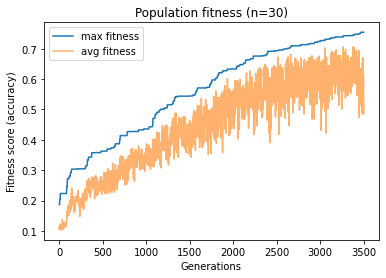

---------------------------------------------------------------------------
Model
Linear (linear)            (in=784, out=32)              #Params: 25121
Linear (linear)            (in=32, out=10)               #Params: 331
Total params: 25452
Accuracy: 0.7543

CPU times: total: 1h 34min 21s
Wall time: 31min 52s


In [188]:
%%time
# initial population
print('Starting training')
t_training = time.time()
population = Population(size=POPULATION_SIZE, n_survivors=SURVIVORS, n_hidden_layers=N_HIDDEN_LAYERS)
population_fitness = population.organism_fitness()
max_fitness = population.max_fitness()
t2 = time.time()
print('Gen', 0, ':',
      population_fitness, '- max:',
      max_fitness,
      '({}s)'.format(round(t2 - t_training, 2)))

# future populations
for generation in range(1, GENERATIONS):
    # breed new population
    t1 = time.time()
    population.breed()

    # evaluate new population
    population_fitness = population.organism_fitness()
    max_fitness = population.max_fitness()
    t2 = time.time()

    print('Gen', generation, ':',
          population_fitness, '- max:',
          max_fitness,
          '({}s)'.format(round(t2 - t1, 2)))

print('Finished training ({})'.format(round(time.time() - t_training, 2)))

# performance of population
population.plot()